**Table of Content**
- Data Cleaning
    - Separating Data
    - Adding Releated Columns
- EDA
    - Movie & TV Show Distribution Analysis
    - Director Analysis
    - Cast Analysis
    - Country Analysis
    - Timeline Analysis
        - All time data Analysis
        - Latest Data Analysis
    - Rating Analysis
    - Duration Analysis
        - Movie Analysis
        - TV Show Analysis
    - Genre/Category Analysis
        - Movie Genre Analysis
        - TV Show Genre Analysis

In [1]:
# import required libraries
import pandas as pd # type: ignore
import datetime
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import matplotlib.gridspec as gridspec # type: ignore

import warnings
warnings.filterwarnings("ignore")

# Data Cleaning

In [2]:
# Read Data
data = pd.read_csv("netflix_titles.csv")

data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
data.shape

(8807, 12)

In [4]:
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [5]:
# Drop irrelevant columns
data = data.drop(columns=['description'])

Missing Values Count

In [6]:
data.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
dtype: int64

Have missing Values in **director, cast, country, date_added, rating and duration** columns.

In [7]:
data["type"].value_counts()

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

In [8]:
# Convert "type" Column to Categorical
data["type"] = data["type"].astype("category")

Fix incorrect columns

In [9]:
# Convert "date_added" to Datetime
data["date_added"] = pd.to_datetime(data["date_added"], format='%B %d, %Y', errors="coerce")   # errors="coerce": Any invalid date strings will be set to NaT (Not a Time)

# Handle Missing date_added Values
mask = data["date_added"].isna()
data.loc[mask, "date_added"] = data.loc[mask, "release_year"].apply(
    lambda x: max(pd.to_datetime(x + 1, format="%Y"), pd.Timestamp(datetime.date(2006, 1, 1))).date())

In [10]:
# Fix Incorrect "rating" Values
mask = data["rating"].isin(["74 min", "84 min", "66 min"])
data.loc[mask, "duration"] = data.loc[mask, "rating"]

# Replaces the rating with the most frequent (mode) rating
data.loc[mask, "rating"] = data["rating"].mode().iloc[0]

# Fill Missing Ratings with the most frequent (mode)
data["rating"] = data["rating"].fillna(data["rating"].mode().iloc[0])

## Separating Data

In [11]:
def flatten_column(data, column_name, new_column_name):
    # Convert strings to lists
    column_data = data[column_name].apply(lambda x: str(x).split(', ')).tolist()
    
    # Create a DataFrame for the processed column
    temp_df = pd.DataFrame(column_data, index=data['show_id'])
    
    # Flatten the DataFrame
    temp_df = (
        temp_df.stack()
        .reset_index(name=new_column_name)
        .drop('level_1', axis=1)
        .set_index('show_id')
    )
    
    # Replace "nan" strings with actual NaN
    temp_df.replace("nan", float('nan'), inplace=True)

    # Remove empty strings if applicable
    if new_column_name == 'country':
        # mask = country_df[country_df['country'] == ''].index
        # country_df.drop(mask, inplace=True)
        mask = temp_df[temp_df['country'] == ''].index
        temp_df.drop(mask, inplace=True)
    
    return temp_df

Flatten **director, cast, country, listed_in** columns and removes it 

In [12]:
# Flatten 'director' column
director_df = flatten_column(data, 'director', 'director')
director_df

,director
show_id,
s1,Kirsten Johnson
s2,NaN
s3,Julien Leclercq
s4,NaN
s5,NaN
...,...
s8803,David Fincher
s8804,NaN
s8805,Ruben Fleischer


In [13]:
# Flatten 'cast' column
cast_df = flatten_column(data, 'cast', 'cast')
cast_df

,cast
show_id,
s1,NaN
s2,Ama Qamata
s2,Khosi Ngema
s2,Gail Mabalane
s2,Thabang Molaba
...,...
s8807,Manish Chaudhary
s8807,Meghna Malik
s8807,Malkeet Rauni


In [14]:
# Flatten 'country' column
country_df = flatten_column(data, 'country', 'country')
country_df

,country
show_id,
s1,United States
s2,South Africa
s3,NaN
s4,NaN
s5,India
...,...
s8803,United States
s8804,NaN
s8805,United States


In [15]:
# Flatten 'listed_in' column
listed_df = flatten_column(data, 'listed_in', 'listed_in')
listed_df

,listed_in
show_id,
s1,Documentaries
s2,International TV Shows
s2,TV Dramas
s2,TV Mysteries
s3,Crime TV Shows
...,...
s8806,Children & Family Movies
s8806,Comedies
s8807,Dramas


In [16]:
data.drop(["cast", "country", "director", "listed_in"], axis=1, inplace=True)

## Adding Releated Columns

In [17]:
# Extracting the Numeric Part of duration
data["duration"] = data["duration"].apply(lambda x: x.split(" ")[0])

# Extracting Year and Month from date_added
data["date_added_year_month"] = data["date_added"].dt.strftime('%Y-%m')

# Extracting the Year of date_added
data["date_added_year"] = data["date_added"].dt.year

# Extracting the Month of date_added
data["date_added_month"] = data["date_added"].dt.month

# Extracting the Month Name of date_added
data["date_added_month_name"] = data["date_added"].dt.month_name()

# Categorizing date_added_year into Periods
data["date_added_period"] = pd.cut(data["date_added_year"], bins=[0, 2005, 2010, 2015, 2022], 
                                labels=["2005", "2006-2010", "2011-2015", "2016-2022"])

In [18]:
# Splitting Data into Movies and TV Shows
movies_df = data.loc[data["type"] == "Movie"]
tv_shows_df = data.loc[data["type"] == "TV Show"]

movies_df.head()

,show_id,type,title,date_added,release_year,rating,duration,date_added_year_month,date_added_year,date_added_month,date_added_month_name,date_added_period
0,s1,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,2021-09,2021,9,September,2016-2022
6,s7,Movie,My Little Pony: A New Generation,2021-09-24,2021,PG,91,2021-09,2021,9,September,2016-2022
7,s8,Movie,Sankofa,2021-09-24,1993,TV-MA,125,2021-09,2021,9,September,2016-2022
9,s10,Movie,The Starling,2021-09-24,2021,PG-13,104,2021-09,2021,9,September,2016-2022
12,s13,Movie,Je Suis Karl,2021-09-23,2021,TV-MA,127,2021-09,2021,9,September,2016-2022


In [19]:
tv_shows_df.head()

,show_id,type,title,date_added,release_year,rating,duration,date_added_year_month,date_added_year,date_added_month,date_added_month_name,date_added_period
1,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022
2,s3,TV Show,Ganglands,2021-09-24,2021,TV-MA,1,2021-09,2021,9,September,2016-2022
3,s4,TV Show,Jailbirds New Orleans,2021-09-24,2021,TV-MA,1,2021-09,2021,9,September,2016-2022
4,s5,TV Show,Kota Factory,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022
5,s6,TV Show,Midnight Mass,2021-09-24,2021,TV-MA,1,2021-09,2021,9,September,2016-2022


In [20]:
director_df.value_counts()

director               
Rajiv Chilaka              22
Jan Suter                  21
Raúl Campos                19
Suhas Kadav                16
Marcus Raboy               16
                           ..
Brandon Camp                1
Juan Antin                  1
Juan Antonio de la Riva     1
Juan Camilo Pinzon          1
María Jose Cuevas           1
Name: count, Length: 4993, dtype: int64

In [21]:
cast_df.value_counts()

cast               
Anupam Kher            43
Shah Rukh Khan         35
Julie Tejwani          33
Naseeruddin Shah       32
Takahiro Sakurai       32
                       ..
Chinmay Kambli          1
Kumiko Aso              1
Kumarakom Vasudevan     1
Kumar Varun             1
Ṣọpẹ́ Dìrísù            1
Name: count, Length: 36439, dtype: int64

In [22]:
country_df.value_counts()

country       
United States     3689
India             1046
United Kingdom     804
Canada             445
France             392
                  ... 
Kazakhstan           1
Jamaica              1
Slovakia             1
Ethiopia             1
Afghanistan          1
Name: count, Length: 126, dtype: int64

In [23]:
# Fill missing values with "Unknown" and reset index for all DataFrames 
for df_ in [director_df, cast_df, country_df, listed_df]:
    df_.fillna("Unknown", inplace=True)
    df_.reset_index(inplace=True) 

In [24]:
def check_missing_values(dataframes):
    missing_values = {}
    for name, df in dataframes.items():
        missing_values[name] = df.isna().sum()
    return missing_values

In [25]:
# Define DataFrames
dataframes = {
    "country_df": country_df,
    "director_df": director_df,
    "listed_df": listed_df,
    "tv_shows_df": tv_shows_df,
    "movies_df": movies_df,
    "main_df": data,
    "cast_df": cast_df
}

# Check missing values
missing_values_summary = check_missing_values(dataframes)

# Print results
for name, missing_values in missing_values_summary.items():
    print(f"Missing values in {name}:\n{missing_values}\n")

Missing values in country_df:
show_id    0
country    0
dtype: int64

Missing values in director_df:
show_id     0
director    0
dtype: int64

Missing values in listed_df:
show_id      0
listed_in    0
dtype: int64

Missing values in tv_shows_df:
show_id                  0
type                     0
title                    0
date_added               0
release_year             0
rating                   0
duration                 0
date_added_year_month    0
date_added_year          0
date_added_month         0
date_added_month_name    0
date_added_period        0
dtype: int64

Missing values in movies_df:
show_id                  0
type                     0
title                    0
date_added               0
release_year             0
rating                   0
duration                 0
date_added_year_month    0
date_added_year          0
date_added_month         0
date_added_month_name    0
date_added_period        0
dtype: int64

Missing values in main_df:
show_id              

In [26]:
country_df.to_csv("D:/Data Analysis Uneeq Internship/netflix/Data Cleaned/country.csv", index=False)
director_df.to_csv("D:/Data Analysis Uneeq Internship/netflix/Data Cleaned/director.csv", index=False)
cast_df.to_csv("D:/Data Analysis Uneeq Internship/netflix/Data Cleaned/cast.csv", index=False)
listed_df.to_csv("D:/Data Analysis Uneeq Internship/netflix/Data Cleaned/listed.csv", index=False)
data.to_csv("D:/Data Analysis Uneeq Internship/netflix/Data Cleaned/NetflixdataCleaned.csv", index=False)
movies_df.to_csv("D:/Data Analysis Uneeq Internship/netflix/Data Cleaned/movies.csv", index=False)
tv_shows_df.to_csv("D:/Data Analysis Uneeq Internship/netflix/Data Cleaned/tv_shows.csv", index=False)

# EDA

In [27]:
country_df = pd.read_csv(r"D:\Data Analysis Uneeq Internship\netflix\Data Cleaned\country.csv")
cast_df = pd.read_csv(r"D:\Data Analysis Uneeq Internship\netflix\Data Cleaned\cast.csv")
listed_df = pd.read_csv(r"D:\Data Analysis Uneeq Internship\netflix\Data Cleaned\listed.csv")
movies_df = pd.read_csv(r"D:\Data Analysis Uneeq Internship\netflix\Data Cleaned\movies.csv", parse_dates=["date_added"])
tv_shows_df = pd.read_csv(r"D:\Data Analysis Uneeq Internship\netflix\Data Cleaned\tv_shows.csv",parse_dates=["date_added"])
director_df = pd.read_csv(r"D:\Data Analysis Uneeq Internship\netflix\Data Cleaned\director.csv")
df = pd.read_csv(r"D:\Data Analysis Uneeq Internship\netflix\Data Cleaned\NetflixdataCleaned.csv",parse_dates=["date_added"])

In [28]:
df.describe( include="all")

,show_id,type,title,date_added,release_year,rating,duration,date_added_year_month,date_added_year,date_added_month,date_added_month_name,date_added_period
count,8807,8807,8807,8807,8807.000000,8807,8807.000000,8807,8807.000000,8807.000000,8807,8807
unique,8807,2,8807,NaN,NaN,14,NaN,114,NaN,NaN,12,3
top,s1,Movie,Dick Johnson Is Dead,NaN,NaN,TV-MA,NaN,2021-07,NaN,NaN,January,2016-2022
freq,1,6131,1,NaN,NaN,3214,NaN,257,NaN,NaN,825,8640
mean,NaN,NaN,NaN,2019-05-04 22:43:58.174179584,2014.180198,NaN,69.848530,NaN,2018.843874,6.590439,NaN,NaN
min,NaN,NaN,NaN,2006-01-01 00:00:00,1925.000000,NaN,1.000000,NaN,2006.000000,1.000000,NaN,NaN
25%,NaN,NaN,NaN,2018-04-01 00:00:00,2013.000000,NaN,2.000000,NaN,2018.000000,4.000000,NaN,NaN
50%,NaN,NaN,NaN,2019-07-01 00:00:00,2017.000000,NaN,88.000000,NaN,2019.000000,7.000000,NaN,NaN
75%,NaN,NaN,NaN,2020-08-18 00:00:00,2019.000000,NaN,106.000000,NaN,2020.000000,10.000000,NaN,NaN
max,NaN,NaN,NaN,2021-09-25 00:00:00,2021.000000,NaN,312.000000,NaN,2021.000000,12.000000,NaN,NaN


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   show_id                8807 non-null   object        
 1   type                   8807 non-null   object        
 2   title                  8807 non-null   object        
 3   date_added             8807 non-null   datetime64[ns]
 4   release_year           8807 non-null   int64         
 5   rating                 8807 non-null   object        
 6   duration               8807 non-null   int64         
 7   date_added_year_month  8807 non-null   object        
 8   date_added_year        8807 non-null   int64         
 9   date_added_month       8807 non-null   int64         
 10  date_added_month_name  8807 non-null   object        
 11  date_added_period      8807 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 825.8+

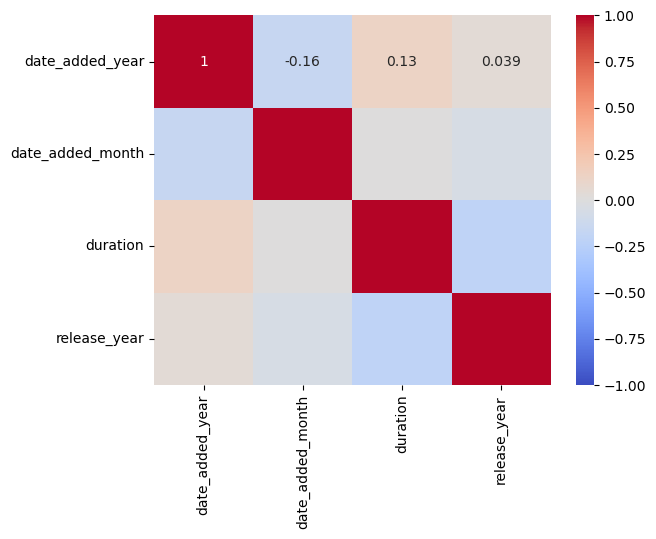

In [30]:
# correlation of movies data
sns.heatmap(movies_df[["date_added_year", "date_added_month", "duration", "release_year"]].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.show()

- There is no strong correlation between the columns of the movie data.

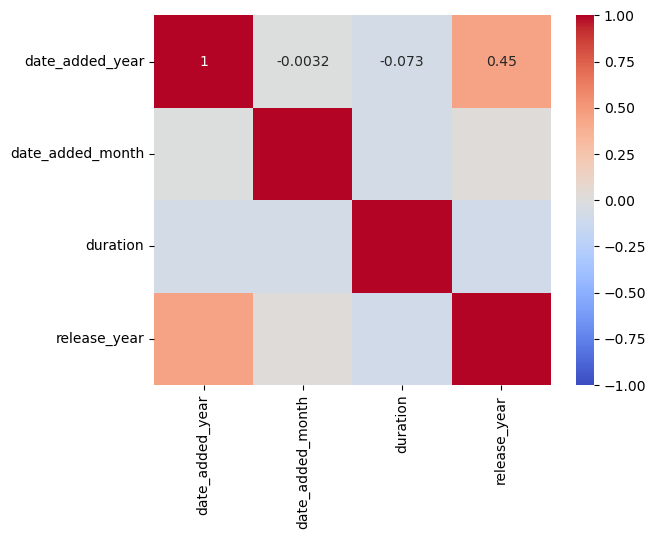

In [31]:
# correlation of tv_shows data
sns.heatmap(tv_shows_df[["date_added_year","date_added_month","duration","release_year"]].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.show()

- There is no strong correlation between the columns of the tv show data.

## Movie & TV Show Distribution Analysis

In [32]:
type_df = df["type"].value_counts()
type_df

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

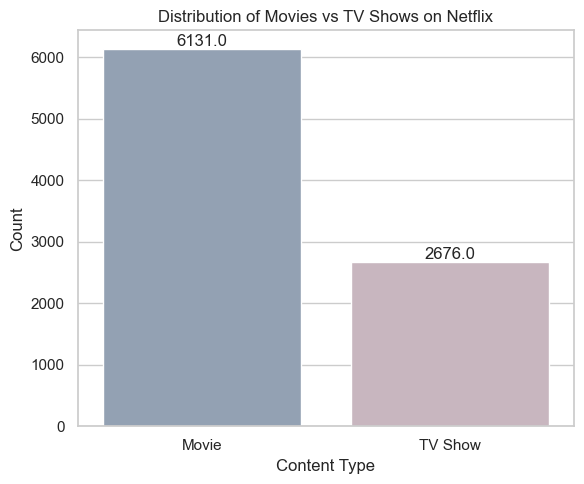

In [33]:
sns.set(style="whitegrid") 

colors = ["#8da1b9", "#cbb3bf"]

plt.figure(figsize=(6, 5))  
ax = sns.countplot(data=df, x="type", palette=colors) 
plt.title("Distribution of Movies vs TV Shows on Netflix")
plt.xlabel("Content Type")
plt.ylabel("Count")

# Add data labels
for p in ax.patches: 
    ax.annotate(
        f"{p.get_height()}",
        (p.get_x() + p.get_width() / 2, p.get_height() + 0.1),
        ha="center",
        va="bottom",
        fontsize=12,
    )

plt.tight_layout()  
plt.show()

Text(0.5, 1.0, 'Movie and TV show percentages')

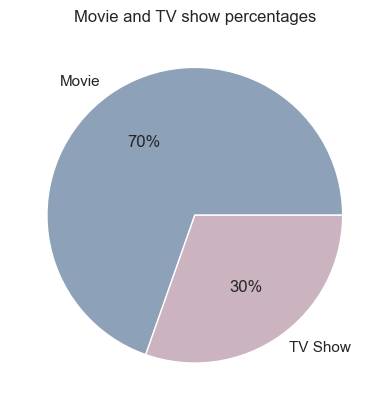

In [34]:
colors = ["#8da1b9", "#cbb3bf"]
plt.pie(type_df, labels=type_df.index, autopct='%.0f%%', colors=colors)
plt.title("Movie and TV show percentages")

- We can say that **movies are more popular than TV shows**.
- This shows that users are more interested in stories that get over in under 2hrs.

In [35]:
tv_movie_df = df.merge(country_df, on="show_id").groupby(["country","type"])["show_id"].count().reset_index().rename(columns={"show_id":"count"}).sort_values(by="count", ascending=False)
tv_movie_df

,country,type,count
175,United States,Movie,2751
66,India,Movie,962
176,United States,TV Show,938
172,United Kingdom,Movie,532
178,Unknown,Movie,440
...,...,...,...
98,Malta,TV Show,1
1,Albania,Movie,1
91,Lithuania,Movie,1
90,Liechtenstein,Movie,1


In [36]:
tv_movie_df = tv_movie_df.pivot(index="country", columns="type", values="count").fillna(0)
tv_movie_df.loc[tv_movie_df["TV Show"]>tv_movie_df["Movie"]].sort_values(by="TV Show", ascending=False)

type,Movie,TV Show
country,,
Japan,119.0,199.0
South Korea,61.0,169.0
Taiwan,19.0,70.0
Colombia,20.0,32.0
Singapore,18.0,23.0
Russia,11.0,16.0
Ukraine,1.0,2.0
Azerbaijan,0.0,1.0
Belarus,0.0,1.0


- Above table consist of those countries which have higher count of tv shows as compared to movies.
- We can see that Japan, South Korea, Taiwan have the biggest difference in number of tv shows compared to movies.

## Director Analysis

In [37]:
director_df.describe()

,show_id,director
count,9612,9612
unique,8807,4994
top,s5888,Unknown
freq,13,2634


In [38]:
director_df.value_counts()

show_id  director        
s3719    Miguel Cohan        2
s1       Kirsten Johnson     1
s632     Unknown             1
s6320    Miguel Conde        1
s6321    Supavitra Babul     1
                            ..
s3658    Peter Sullivan      1
s3659    Aditya Sarpotdar    1
s366     Najwa Najjar        1
s3660    Unknown             1
s999     Unknown             1
Name: count, Length: 9611, dtype: int64

In [39]:
director_df.drop_duplicates()

,show_id,director
0,s1,Kirsten Johnson
1,s2,Unknown
2,s3,Julien Leclercq
3,s4,Unknown
4,s5,Unknown
...,...,...
9607,s8803,David Fincher
9608,s8804,Unknown
9609,s8805,Ruben Fleischer
9610,s8806,Peter Hewitt


In [40]:
merge_director_df = df.merge(director_df,on='show_id',how='inner')
merge_director_df.head()

,show_id,type,title,date_added,release_year,rating,duration,date_added_year_month,date_added_year,date_added_month,date_added_month_name,date_added_period,director
0,s1,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,2021-09,2021,9,September,2016-2022,Kirsten Johnson
1,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,Unknown
2,s3,TV Show,Ganglands,2021-09-24,2021,TV-MA,1,2021-09,2021,9,September,2016-2022,Julien Leclercq
3,s4,TV Show,Jailbirds New Orleans,2021-09-24,2021,TV-MA,1,2021-09,2021,9,September,2016-2022,Unknown
4,s5,TV Show,Kota Factory,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,Unknown


In [41]:
top_10_director = director_df["director"].value_counts()[:11].reset_index()
top_10_director = top_10_director.iloc[:11]

movie_director_df = merge_director_df.loc[merge_director_df["type"]=="Movie"]["director"].value_counts()[1:11].reset_index()
tv_director_df = merge_director_df.loc[merge_director_df["type"]=="TV Show"]["director"].value_counts()[1:11].reset_index()
 
print("Overall Top Director")
print(top_10_director)

print("\n\nMovie Top Director")
print(movie_director_df)

print("\nTV Show Top Director")
tv_director_df

Overall Top Director
               director  count
0               Unknown   2634
1         Rajiv Chilaka     22
2             Jan Suter     21
3           Raúl Campos     19
4           Suhas Kadav     16
5          Marcus Raboy     16
6             Jay Karas     15
7   Cathy Garcia-Molina     13
8       Martin Scorsese     12
9           Jay Chapman     12
10      Youssef Chahine     12


Movie Top Director
              director  count
0        Rajiv Chilaka     22
1            Jan Suter     21
2          Raúl Campos     19
3          Suhas Kadav     16
4            Jay Karas     15
5         Marcus Raboy     15
6  Cathy Garcia-Molina     13
7      Youssef Chahine     12
8      Martin Scorsese     12
9          Jay Chapman     12

TV Show Top Director


,director,count
0,Alastair Fothergill,3
1,Ken Burns,3
2,Iginio Straffi,2
3,Gautham Vasudev Menon,2
4,Hsu Fu-chun,2
5,Stan Lathan,2
6,Shin Won-ho,2
7,Joe Berlinger,2
8,Lynn Novick,2
9,Rob Seidenglanz,2


- Above table shows the list of top directors present in movies and tv shows.
- There is lot of missing values in this data, which have been replaced by "Unknown".
- **Rajiv Chilaka** is the most popular director in **Movies**.
- **Alastair Fothergill** is the most popular director in TV **Shows**.

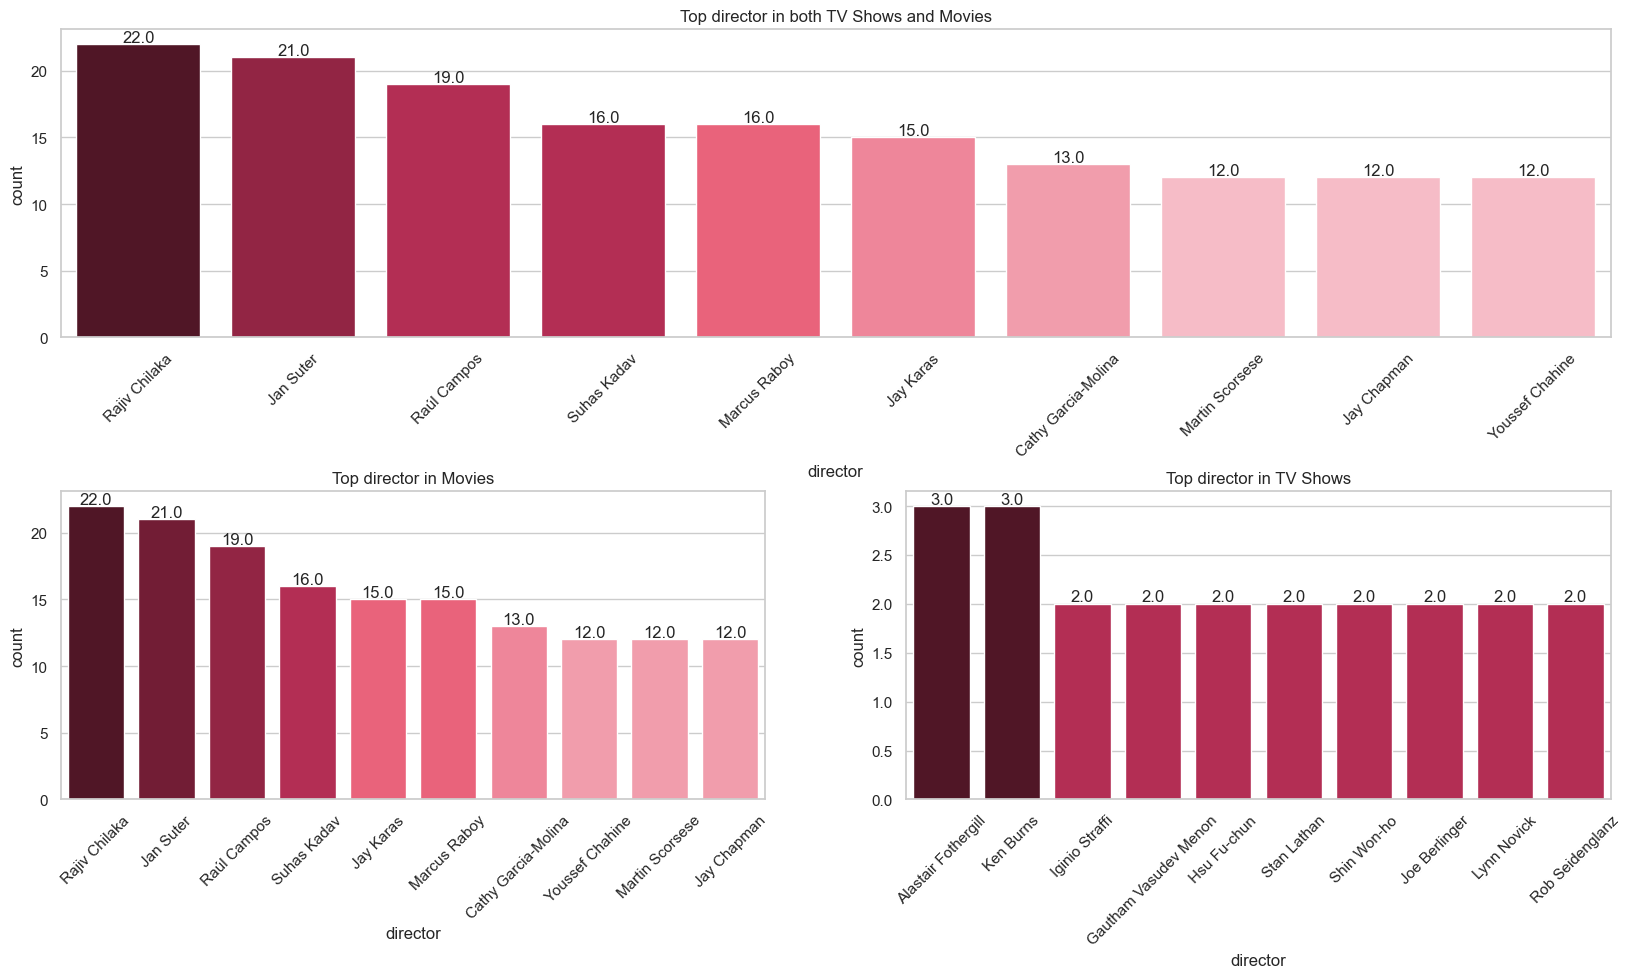

In [42]:
# Define the color palette
colors = ["#590d22", "#a4133c", "#c9184a", "#c9184a", "#ff4d6d", 
          "#ff758f", "#ff8fa3", "#ffb3c1", "#ffb3c1", "#ffb3c1"]

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], hspace=0.5)

ax1 = plt.subplot(gs[0, :])
sns.barplot(data=top_10_director.iloc[1:11], x="director", y="count", ax=ax1, palette=colors)
ax1.set_title("Top director in both TV Shows and Movies")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Add data labels to ax1
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

colors = ["#590d22", "#800f2f", "#a4133c", "#c9184a", "#ff4d6d", "#ff4d6d", "#ff758f", "#ff8fa3", "#ff8fa3", "#ff8fa3"]

ax2 = plt.subplot(gs[1, 0])
sns.barplot(data=movie_director_df, x="director", y="count", ax=ax2, palette=colors)
ax2.set_title("Top director in Movies")
ax2.tick_params(axis='x', labelrotation=45)

# Add data labels to ax2
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

colors = ["#590d22", "#590d22", "#c9184a", "#c9184a", "#c9184a", "#c9184a", "#c9184a", "#c9184a", "#c9184a", "#c9184a"]

ax3 = plt.subplot(gs[1, 1])
sns.barplot(data=tv_director_df, x="director", y="count", ax=ax3, palette=colors)
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_title("Top director in TV Shows")

# Add data labels to ax3
for p in ax3.patches:
    ax3.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


In [43]:
# Merge DataFrames
merged_df = df.merge(director_df, on='show_id', how='inner')
merged_df = merged_df.merge(country_df, on='show_id', how='inner')

# Filter for valid data
merged_df = merged_df[(merged_df['country'] != 'Unknown') & (merged_df['director'] != 'Unknown')]

# Group by country and count director members for TV shows and movies
director_count_df = merged_df.groupby('country').agg(
  tv_director_count=('type', lambda x: (x == 'TV Show').sum()),
  movie_director_count=('type', lambda x: (x == 'Movie').sum())
).reset_index()

# Sort by TV director count in descending order and reset index
director_count_df = director_count_df.sort_values(by='tv_director_count', ascending=False).reset_index(drop=True)
director_count_df.head(20)

,country,tv_director_count,movie_director_count
0,United States,91,3057
1,India,32,1013
2,United Kingdom,31,558
3,Spain,22,183
4,Japan,19,151
5,Taiwan,18,20
6,South Korea,16,62
7,France,14,349
8,Brazil,14,71
9,Canada,12,359


Text(0.5, 1.0, 'Cast Count by Country')

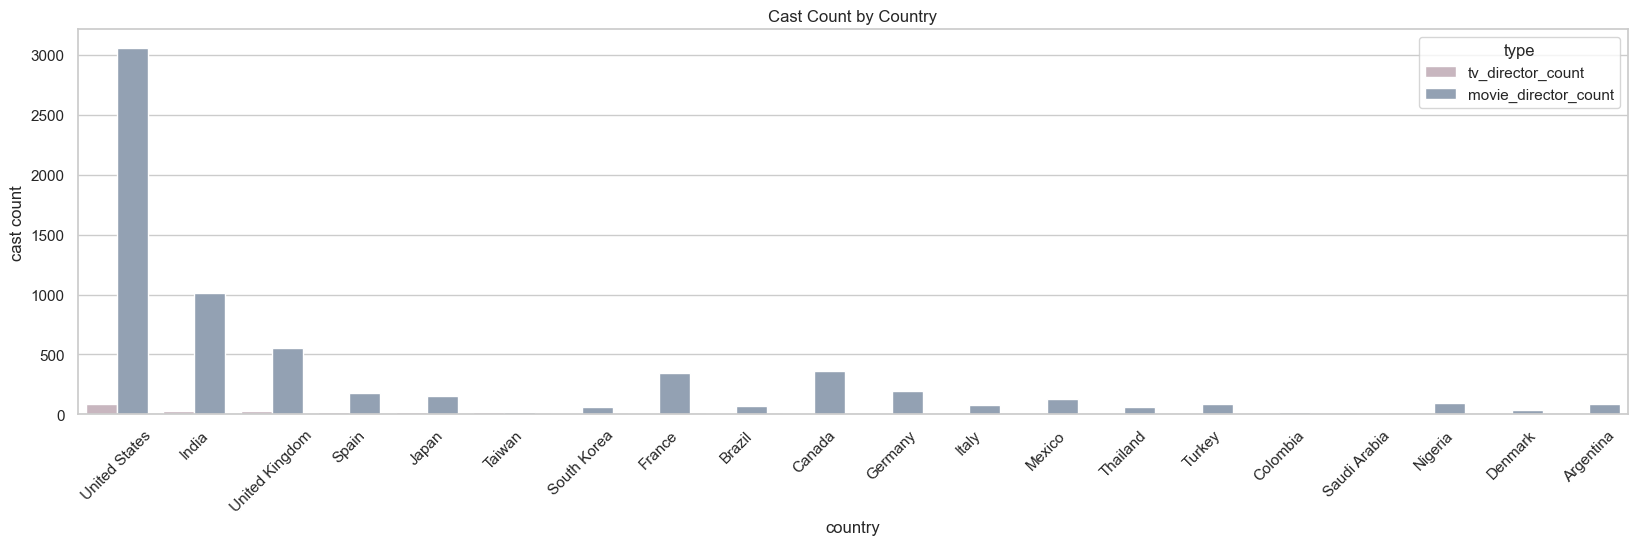

In [44]:
colors = ["#cbb3bf", "#8da1b9"]

temp_df=director_count_df.head(20).melt(id_vars=['country'],var_name="type", value_name='cast count')
plt.figure(figsize=(20,5))
lp=sns.barplot(data=temp_df, x="country", y="cast count", hue="type", palette=colors)
plt.xticks(rotation=45)
plt.title("Cast Count by Country")

- The greater number of movie director compared to tv show director.

## Cast Analysis

In [45]:
cast_df.describe()

,show_id,cast
count,64951,64951
unique,8807,36440
top,s1855,Unknown
freq,50,825


In [46]:
merge_cast_df = df.merge(cast_df,on='show_id',how='inner')
merge_cast_df.head()

,show_id,type,title,date_added,release_year,rating,duration,date_added_year_month,date_added_year,date_added_month,date_added_month_name,date_added_period,cast
0,s1,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,2021-09,2021,9,September,2016-2022,Unknown
1,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,Ama Qamata
2,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,Khosi Ngema
3,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,Gail Mabalane
4,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,Thabang Molaba


In [47]:
top_10_cast = cast_df["cast"].value_counts()[:11].reset_index()
top_10_cast = top_10_cast.iloc[:11]

movie_cast_df = merge_cast_df.loc[merge_cast_df["type"]=="Movie"]["cast"].value_counts()[1:11].reset_index()
tv_cast_df = merge_cast_df.loc[merge_cast_df["type"]=="TV Show"]["cast"].value_counts()[1:11].reset_index()

print("Overall Top Cast")
print(top_10_cast)

print("\n\nMovie Top Cast")
print(movie_cast_df)

print("\nTV Show Top Cast")
tv_cast_df

Overall Top Cast
                cast  count
0            Unknown    825
1        Anupam Kher     43
2     Shah Rukh Khan     35
3      Julie Tejwani     33
4   Naseeruddin Shah     32
5   Takahiro Sakurai     32
6       Rupa Bhimani     31
7       Akshay Kumar     30
8            Om Puri     30
9          Yuki Kaji     29
10  Amitabh Bachchan     28


Movie Top Cast
               cast  count
0       Anupam Kher     42
1    Shah Rukh Khan     35
2  Naseeruddin Shah     32
3           Om Puri     30
4      Akshay Kumar     30
5      Paresh Rawal     28
6     Julie Tejwani     28
7  Amitabh Bachchan     28
8      Rupa Bhimani     27
9       Boman Irani     27

TV Show Top Cast


,cast,count
0,Takahiro Sakurai,25
1,Yuki Kaji,19
2,Daisuke Ono,17
3,Junichi Suwabe,17
4,Ai Kayano,17
5,Yuichi Nakamura,16
6,Yoshimasa Hosoya,15
7,Jun Fukuyama,15
8,David Attenborough,14
9,Yoshitsugu Matsuoka,13


- The above table shows the list of **top cast present** in movies and tv shows.
- There are lot of missing values in this data, which have been replaced by "Unknown".
- **Anupam Kher** appears to be in **maximum** number of content present on Netflix.
- **Anupam Kher** appears to be in **maximum** number of Netflix's movie content.
- **Takahiro Sakurai** appears to be in **maximum** of Netflix's tv show content.

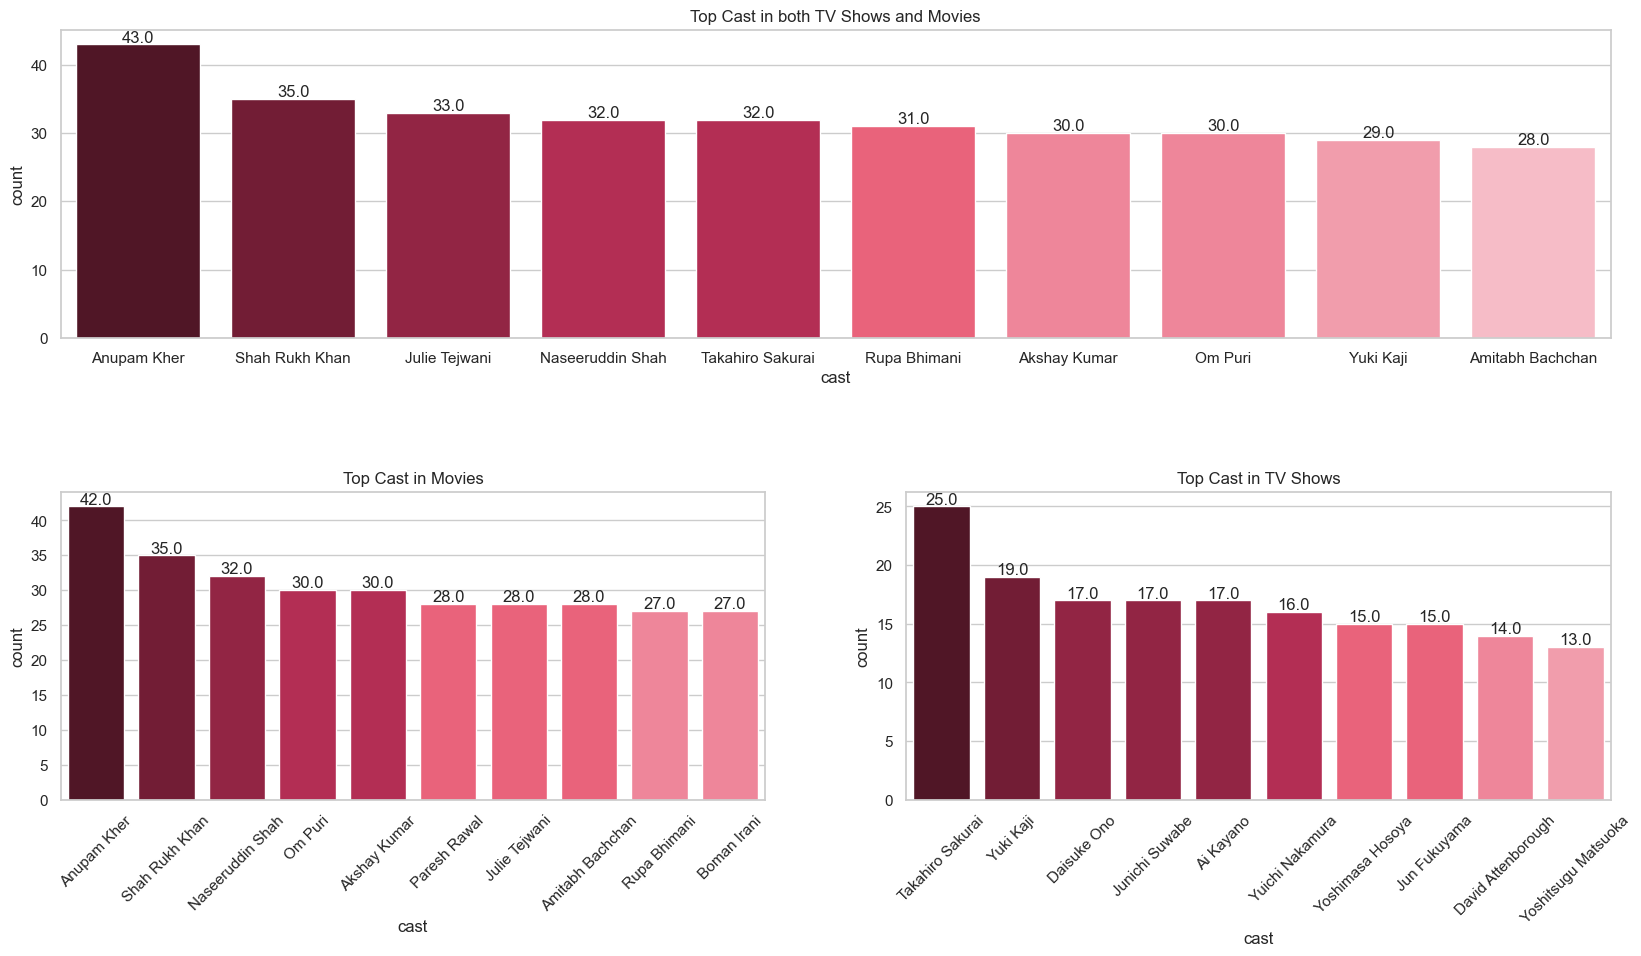

In [48]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], hspace=0.5)

colors = ["#590d22", "#800f2f", "#a4133c", "#c9184a", "#c9184a", 
          "#ff4d6d", "#ff758f", "#ff758f", "#ff8fa3", "#ffb3c1"]

ax1 = plt.subplot(gs[0, :])
sns.barplot(data=top_10_cast.iloc[1:11], x="cast", y="count", ax=ax1, palette=colors)
# ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title("Top Cast in both TV Shows and Movies")

# Add data labels to ax1
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    

colors = ["#590d22", "#800f2f", "#a4133c", "#c9184a", "#c9184a",
          "#ff4d6d", "#ff4d6d", "#ff4d6d", "#ff758f", "#ff758f"]

ax2 = plt.subplot(gs[1, 0])
sns.barplot(data=movie_cast_df, x="cast", y="count", ax=ax2, palette=colors)
ax2.set_title("Top Cast in Movies")
ax2.tick_params(axis='x', labelrotation=45)

# Add data labels to ax2
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')


colors = ["#590d22", "#800f2f", "#a4133c", "#a4133c", "#a4133c", 
          "#c9184a", "#ff4d6d", "#ff4d6d", "#ff758f", "#ff8fa3"]

ax3 = plt.subplot(gs[1, 1])
sns.barplot(data=tv_cast_df, x="cast", y="count", ax=ax3, palette=colors)
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_title("Top Cast in TV Shows")

# Add data labels to ax3
for p in ax3.patches:
    ax3.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')


plt.tight_layout()
plt.show()

- **Anupam Kher** is the most popular actor in the movies section and overall section.
- **Takahiro Sakurai** is the most popular actor in the TV show section.

In [49]:
# Merge DataFrames
merged_df = df.merge(cast_df, on='show_id', how='inner')
merged_df = merged_df.merge(country_df, on='show_id', how='inner')

# Filter for valid data
merged_df = merged_df[(merged_df['country'] != 'Unknown') & (merged_df['cast'] != 'Unknown')]

# Group by country and count cast members for TV shows and movies
cast_count_df = merged_df.groupby('country').agg(
  tv_cast_count=('type', lambda x: (x == 'TV Show').sum()),
  movie_cast_count=('type', lambda x: (x == 'Movie').sum())
).reset_index()

# Sort by TV cast count in descending order and reset index
cast_count_df = cast_count_df.sort_values(by='tv_cast_count', ascending=False).reset_index(drop=True)
cast_count_df.head(20)

,country,tv_cast_count,movie_cast_count
0,United States,6578,20485
1,Japan,2329,1124
2,United Kingdom,1572,3751
3,South Korea,1306,481
4,Canada,1033,2486
5,Mexico,710,734
6,France,685,2409
7,Spain,600,1303
8,Taiwan,508,131
9,Australia,450,707


Text(0.5, 1.0, 'Cast Count by Country')

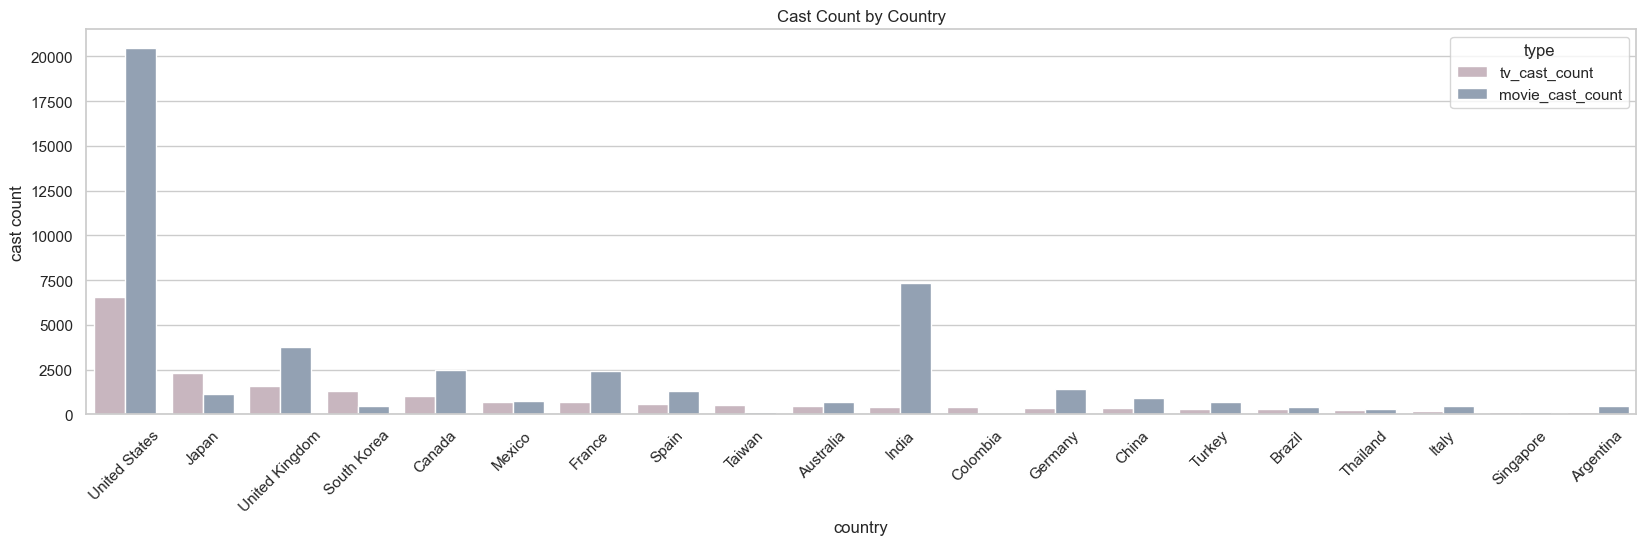

In [50]:
colors = ["#cbb3bf", "#8da1b9"]

temp_df=cast_count_df.head(20).melt(id_vars=['country'],var_name="type", value_name='cast count')
plt.figure(figsize=(20,5))
lp=sns.barplot(data=temp_df, x="country", y="cast count", hue="type", palette=colors)
plt.xticks(rotation=45)
plt.title("Cast Count by Country")

- The data suggests a higher frequency of TV show consumption in **Japan, South Korea, and Taiwan**, as evidenced by the greater number of TV show casts compared to movie casts.

## Country Analysis

In [51]:
country_df.describe()

,show_id,country
count,10840,10840
unique,8805,127
top,s6234,United States
freq,12,3689


In [52]:
top_20_country=country_df["country"].value_counts()[:20]
top_20_country

country
United States     3689
India             1046
Unknown            831
United Kingdom     804
Canada             445
France             392
Japan              318
Spain              232
South Korea        230
Germany            226
Mexico             169
China              162
Australia          160
Egypt              117
Turkey             113
Hong Kong          105
Nigeria            103
Italy              100
Brazil              97
Argentina           91
Name: count, dtype: int64

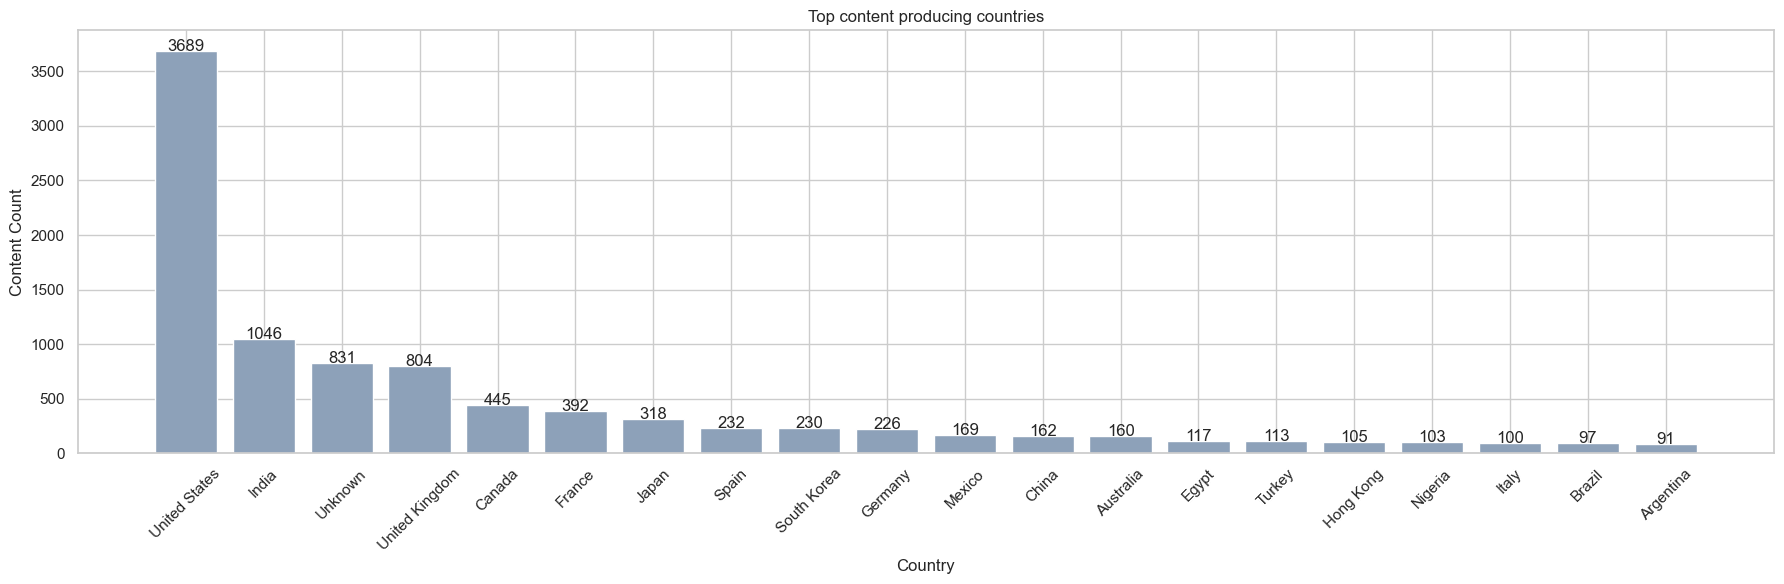

In [53]:
# Top content producing countries
plt.figure(figsize=(18, 6))
plt.bar(top_20_country.index, top_20_country, color="#8da1b9")
plt.xticks(rotation=45)
plt.ylabel("Content Count")
plt.xlabel("Country")
plt.title("Top content producing countries")

# Add data labels using for loop
for idx, value in enumerate(top_20_country):
  plt.text(idx, value + 0.1, str(value), ha='center')  # Adjust the offset (0.1 here) as needed

plt.tight_layout()
plt.show()

- We can see that **USA** is a top content producer.
- Countries like **India, UK, Canada, France, Japan, Spain, South Korea and Germany** have lot of scope for improvement.
- Countries after Germany have a very high scope for improvement.

## Timeline Analysis

### All time data Analysis

In [54]:
timeline = df.groupby(["date_added_year_month","type"])["show_id"].count().reset_index()
timeline.head()

,date_added_year_month,type,show_id
0,2006-01,TV Show,10
1,2008-01,Movie,1
2,2008-02,TV Show,1
3,2009-01,TV Show,1
4,2009-05,Movie,1


[Text(0, 0, '2006-01'),
 Text(5, 0, '2009-11'),
 Text(10, 0, '2011-09'),
 Text(15, 0, '2012-12'),
 Text(20, 0, '2013-10'),
 Text(25, 0, '2014-04'),
 Text(30, 0, '2014-10'),
 Text(35, 0, '2015-03'),
 Text(40, 0, '2015-08'),
 Text(45, 0, '2016-01'),
 Text(50, 0, '2016-06'),
 Text(55, 0, '2016-11'),
 Text(60, 0, '2017-04'),
 Text(65, 0, '2017-09'),
 Text(70, 0, '2018-02'),
 Text(75, 0, '2018-07'),
 Text(80, 0, '2018-12'),
 Text(85, 0, '2019-05'),
 Text(90, 0, '2019-10'),
 Text(95, 0, '2020-03'),
 Text(100, 0, '2020-08'),
 Text(105, 0, '2021-01'),
 Text(110, 0, '2021-06')]

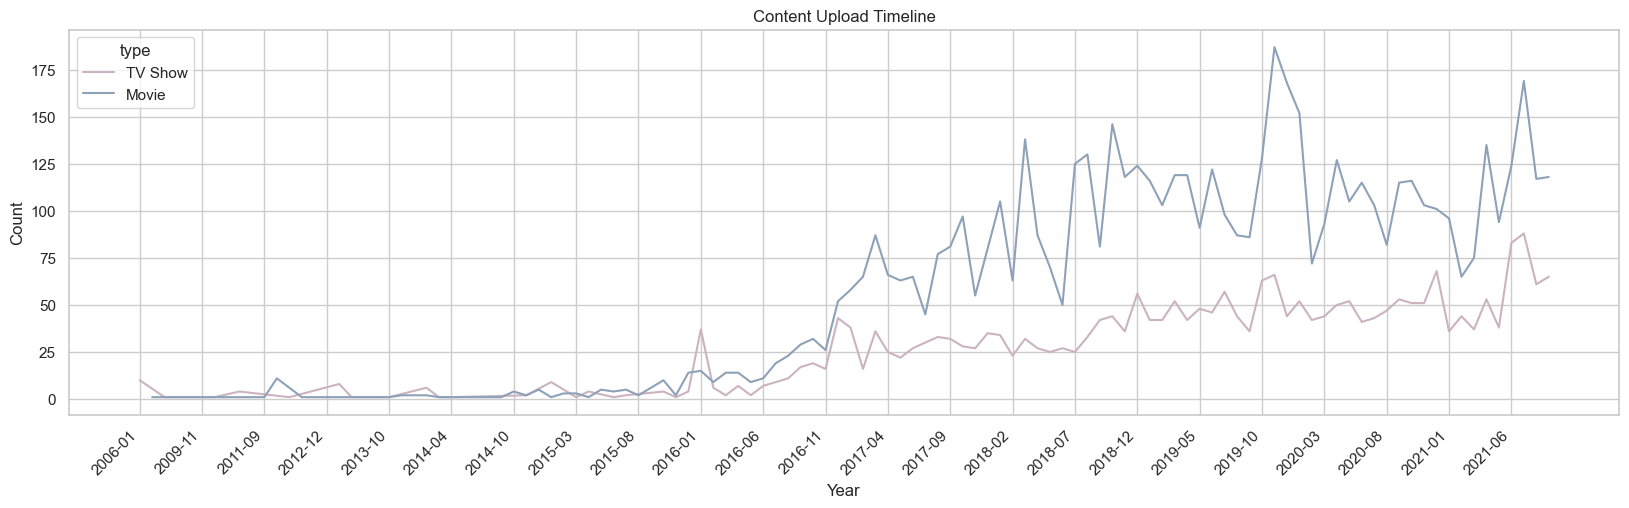

In [55]:
colors = ["#cbb3bf", "#8da1b9"]

plt.figure(figsize=(20,5))
l=sns.lineplot(data=timeline, x="date_added_year_month", y="show_id", hue="type", palette=colors)
l.set(xlabel="Year", ylabel="Count")
l.set_title("Content Upload Timeline")
l.set_xticks(l.get_xticks()[::5])
l.set_xticklabels(l.get_xticklabels(), rotation=45, ha='right')

- We can see that majority of content got added **after 2015**.
- This shows that **Movies are more popular than TV Shows**.

In [56]:
monthly_release = df.groupby(["date_added_month","date_added_month_name","type"])["show_id"].count().reset_index()
monthly_release.head()

,date_added_month,date_added_month_name,type,show_id
0,1,January,Movie,546
1,1,January,TV Show,279
2,2,February,Movie,382
3,2,February,TV Show,175
4,3,March,Movie,529


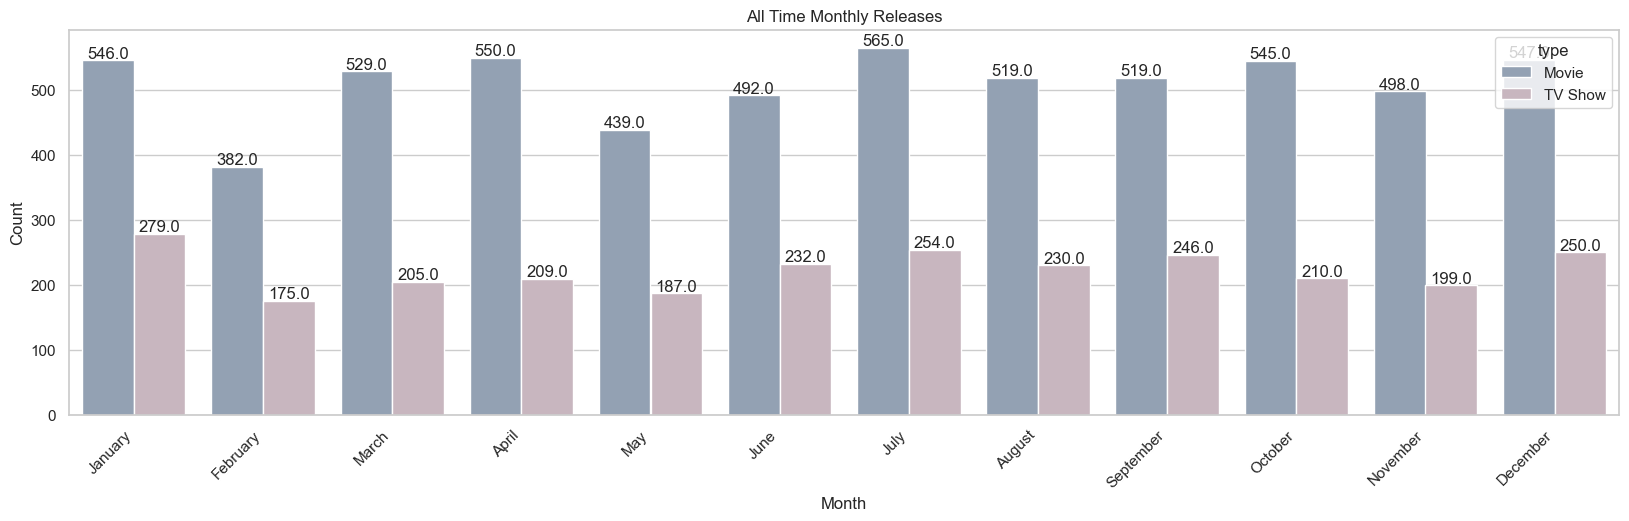

In [57]:
colors = ["#8da1b9", "#cbb3bf"]

plt.figure(figsize=(20, 5))
lp = sns.barplot(data=monthly_release, x="date_added_month_name", y="show_id", hue="type", palette=colors)
lp.set(xlabel="Month", ylabel="Count")
lp.set_title("All Time Monthly Releases")

# Add data labels
for p in lp.patches:
    lp.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

- It looks like **January, April, July, and December** are the busiest months for new content releases. 
- This might be a good time to launch new tv shows or movies.

### Latest Data Analysis

In [58]:
latest_data = df.loc[df["date_added_period"].isin(["2016-2022"])]

In [59]:
monthly_release_latest = latest_data.groupby(["date_added_month","date_added_month_name","type"])["show_id"].count().reset_index()
monthly_release.head()

,date_added_month,date_added_month_name,type,show_id
0,1,January,Movie,546
1,1,January,TV Show,279
2,2,February,Movie,382
3,2,February,TV Show,175
4,3,March,Movie,529


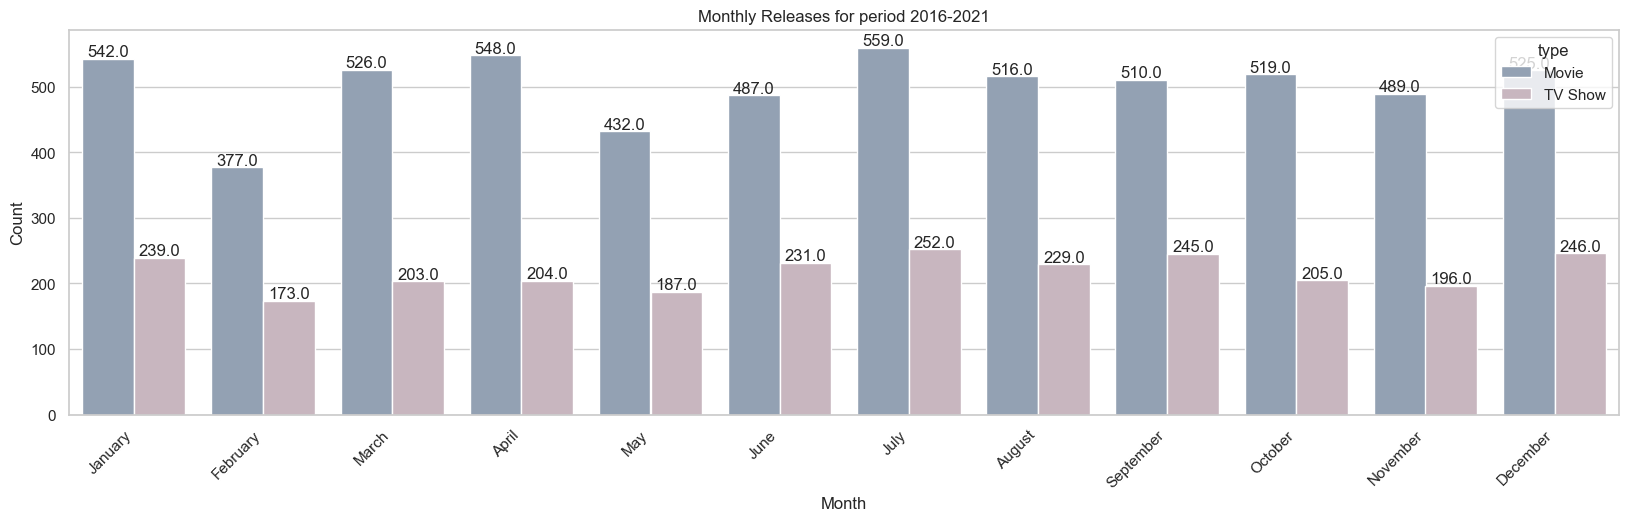

In [60]:
colors = ["#8da1b9", "#cbb3bf"]

plt.figure(figsize=(20, 5))
lp = sns.barplot(data=monthly_release_latest, x="date_added_month_name", y="show_id", hue="type", palette=colors)
lp.set(xlabel="Month", ylabel="Count")
lp.set_title("Monthly Releases for period 2016-2021")

# Add data labels
for p in lp.patches:
    lp.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45, ha='right') 
plt.show()

- We can see that **January, April, July and December** months has highest number of content added even for recent data.
- This seems to be ideal time to release content.

Text(0.5, 1.0, 'Movie realease year distribution')

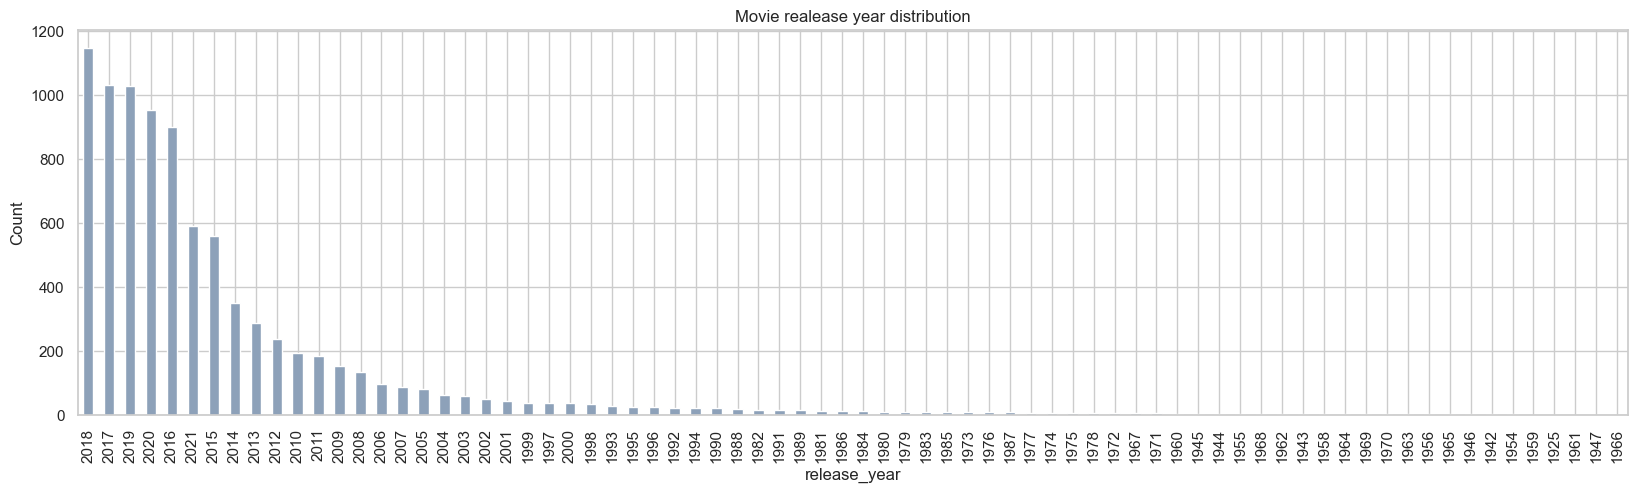

In [61]:
plt.figure(figsize=(20,5))
df["release_year"].value_counts().plot(kind="bar", color="#8da1b9")
plt.ylabel("Count")
plt.title("Movie realease year distribution")

- The platform has seen a substantial increase in content released after 2015. 
- This growth strongly suggests that Netflix is a preferred distribution choice for an expanding number of content producers.

## Rating Analysis

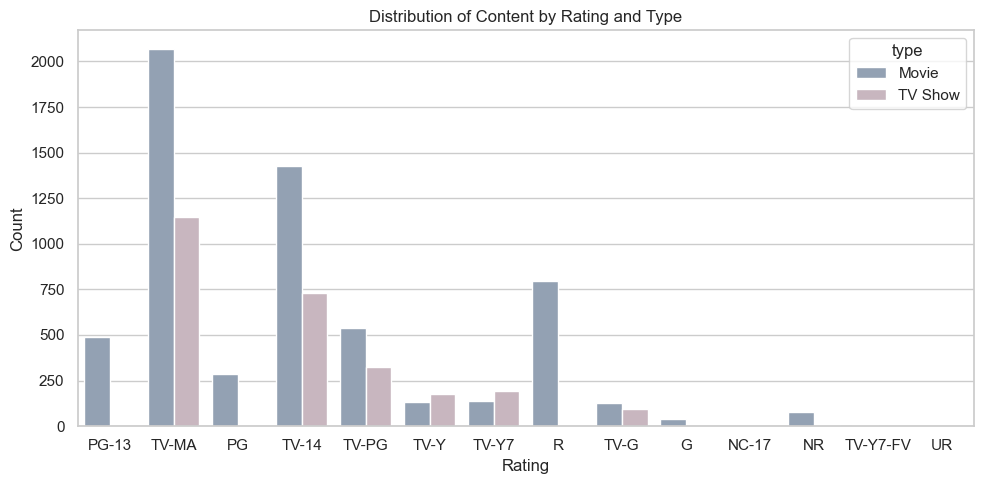

In [62]:
colors = ["#8da1b9", "#cbb3bf"]

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x="rating", hue="type", palette=colors) 
plt.title("Distribution of Content by Rating and Type")
plt.xlabel("Rating")
plt.ylabel("Count")

# # Add data labels
# for p in ax.patches:
#     ax.annotate(f"{p.get_height()}", 
#                 (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='bottom', 
#                 fontsize=8) 

plt.tight_layout()
plt.show()

- From above plot we can say that **TV-MA** and **TV-14** rated content is the most popular.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'PG-13'),
  Text(1, 0, 'TV-MA'),
  Text(2, 0, 'PG'),
  Text(3, 0, 'TV-14'),
  Text(4, 0, 'TV-PG'),
  Text(5, 0, 'TV-Y'),
  Text(6, 0, 'TV-Y7'),
  Text(7, 0, 'R'),
  Text(8, 0, 'TV-G'),
  Text(9, 0, 'G'),
  Text(10, 0, 'NC-17'),
  Text(11, 0, 'NR'),
  Text(12, 0, 'TV-Y7-FV'),
  Text(13, 0, 'UR')])

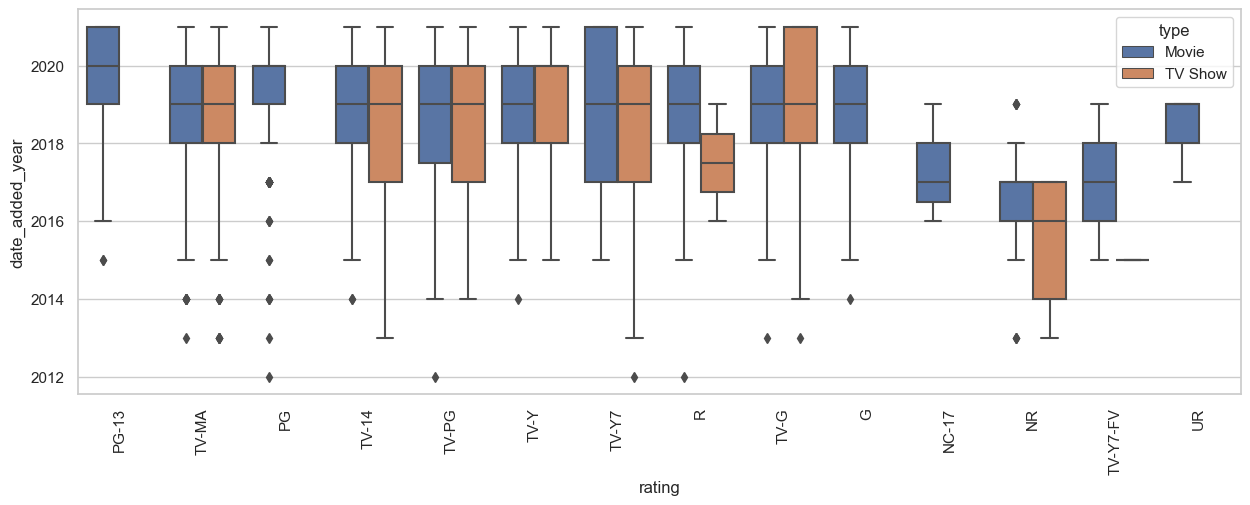

In [63]:
plt.figure(figsize=(15, 5))
rating_df = df.loc[df['date_added_year'] >= 2012]
sns.boxplot(data=rating_df, x="rating", y="date_added_year", hue="type")
plt.xticks(rotation=90)

- Majority of the content was added during **2017 - 2020**.

## Duration Analysis

### Movie Analysis

In [64]:
movies_df["duration"].value_counts()

duration
90     152
94     146
97     146
93     146
91     144
      ... 
208      1
5        1
16       1
186      1
191      1
Name: count, Length: 205, dtype: int64

Text(0.5, 0, 'Duration (minutes)')

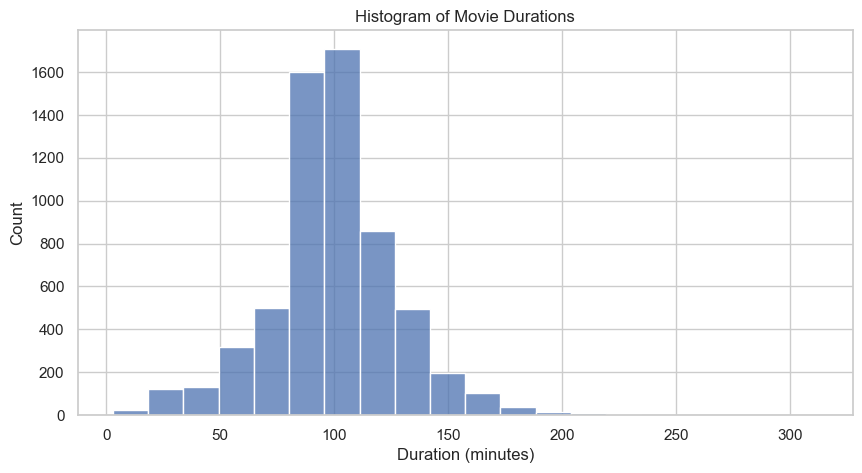

In [65]:
plt.figure(figsize=(10,5))
sns.histplot(data=movies_df, x="duration", bins=20)
plt.title("Histogram of Movie Durations")
plt.xlabel("Duration (minutes)")

- We can see that majority of the movies have a duration of **90min - 120min**.
- This shows that people are highly interested in movies that are around **2 hrs**.

Text(0.5, 1.0, 'Duration of Movies')

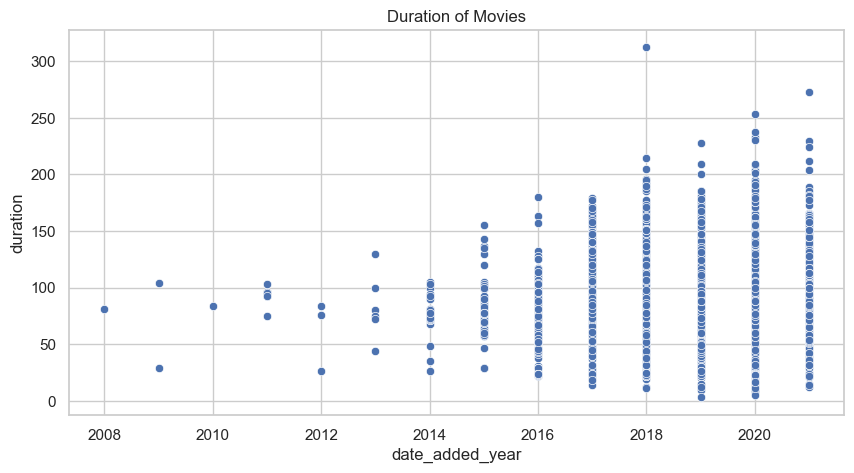

In [66]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=movies_df, x="date_added_year", y="duration")
plt.title("Duration of Movies")

- Movie durations exhibit a mixed trend over time, with periods of both increase and decrease.

Text(0.5, 1.0, 'Movie Duration vs. Date Added Month')

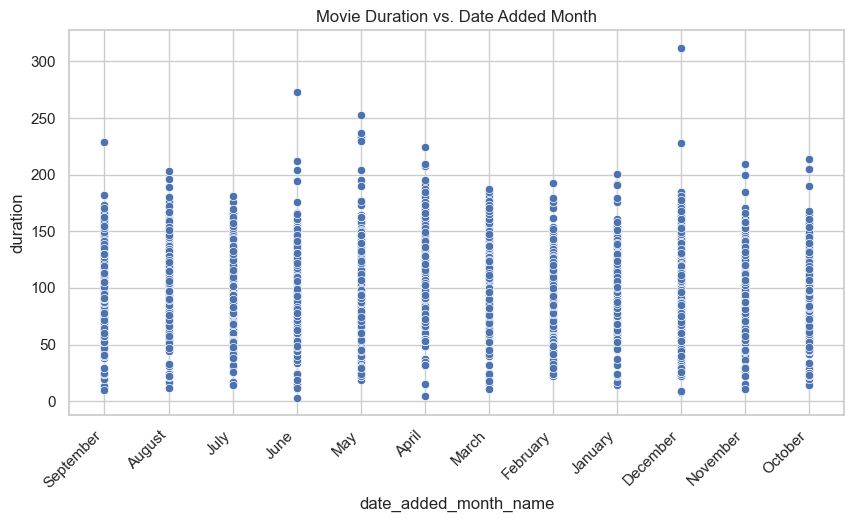

In [67]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=movies_df, x="date_added_month_name", y="duration")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  

plt.title("Movie Duration vs. Date Added Month")

- No clear pattern exists between movie duration and the month they are added.

### TV Show Analysis

In [68]:
tv_shows_df["duration"].value_counts()

duration
1     1793
2      425
3      199
4       95
5       65
6       33
7       23
8       17
9        9
10       7
13       3
15       2
12       2
11       2
17       1
Name: count, dtype: int64

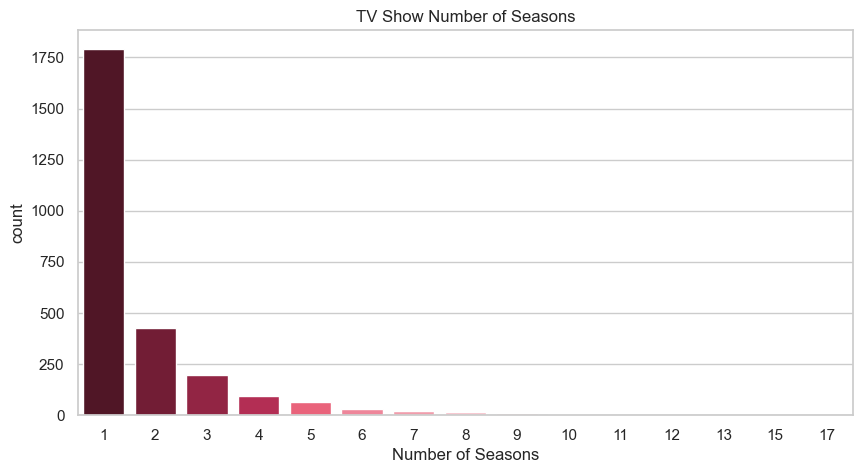

In [69]:
colors = ["#590d22", "#800f2f", "#a4133c", "#c9184a", "#ff4d6d", 
          "#ff758f", "#ff8fa3", "#ffb3c1", "#ffccd5", "#fff0f3"]

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=tv_shows_df, x="duration", palette=colors)
plt.title("TV Show Number of Seasons")
plt.xlabel("Number of Seasons")

# # Add data labels
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='bottom', 
#                 fontsize=10)
    
plt.show()

- We can see that majority of the tv shows have a duration of 1 season.
- This shows that majority of the users like tv shows that end their story in 1 season.

In [70]:
temp_df = tv_shows_df.groupby(["date_added_year","duration"])["show_id"].count().reset_index()
temp_df

,date_added_year,duration,show_id
0,2006,3,1
1,2006,5,2
2,2006,7,1
3,2006,8,2
4,2006,10,2
...,...,...,...
86,2021,8,1
87,2021,9,2
88,2021,10,1
89,2021,13,1


Text(0.5, 1.0, 'Duration of Shows over years')

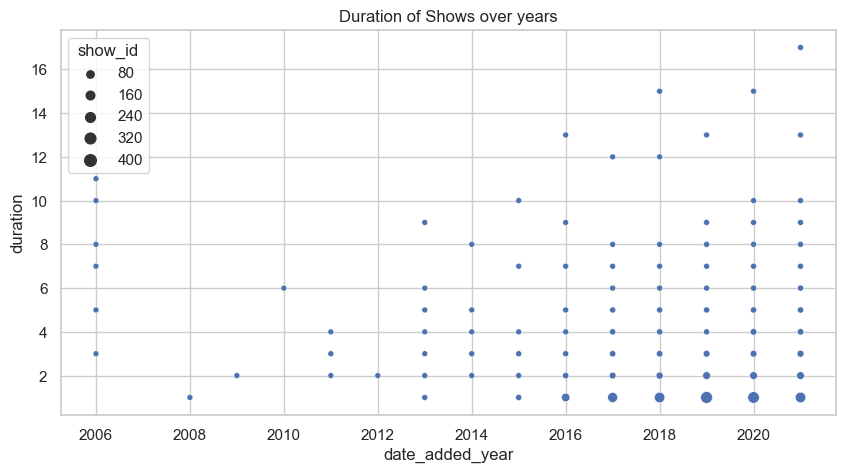

In [71]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=temp_df, x="date_added_year", y="duration", size="show_id")
plt.title("Duration of Shows over years")

In [72]:
temp_df = tv_shows_df.groupby(["date_added_month_name","duration"])["show_id"].count().reset_index()
temp_df

,date_added_month_name,duration,show_id
0,April,1,148
1,April,2,29
2,April,3,14
3,April,4,6
4,April,5,3
...,...,...,...
101,September,5,7
102,September,6,4
103,September,7,2
104,September,8,4


Text(0.5, 1.0, 'TV Show Duration vs. Date Added Month')

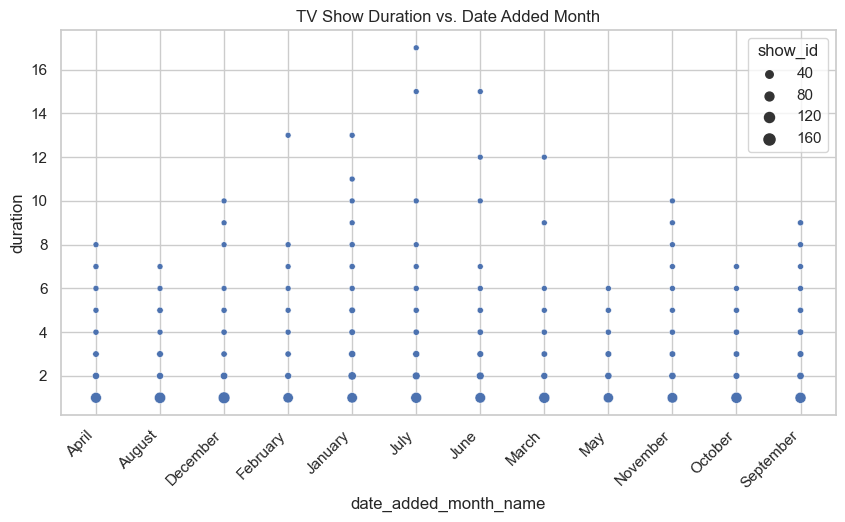

In [73]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=temp_df, x="date_added_month_name", y="duration", size="show_id")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  

plt.title("TV Show Duration vs. Date Added Month")

- No clear pattern exists between tv show number of season and the month they are added.

## Genre/Category Analysis

In [74]:
listed_df.describe()

,show_id,listed_in
count,19323,19323
unique,8807,42
top,s8807,International Movies
freq,3,2752


In [75]:
top_10_listed = listed_df["listed_in"].value_counts()[:10].reset_index()
top_10_listed

,listed_in,count
0,International Movies,2752
1,Dramas,2427
2,Comedies,1674
3,International TV Shows,1351
4,Documentaries,869
5,Action & Adventure,859
6,TV Dramas,763
7,Independent Movies,756
8,Children & Family Movies,641
9,Romantic Movies,616


In [76]:
merge_listed_df = df.merge(listed_df, on='show_id', how='inner')
merge_listed_df.head()

,show_id,type,title,date_added,release_year,rating,duration,date_added_year_month,date_added_year,date_added_month,date_added_month_name,date_added_period,listed_in
0,s1,Movie,Dick Johnson Is Dead,2021-09-25,2020,PG-13,90,2021-09,2021,9,September,2016-2022,Documentaries
1,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,International TV Shows
2,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,TV Dramas
3,s2,TV Show,Blood & Water,2021-09-24,2021,TV-MA,2,2021-09,2021,9,September,2016-2022,TV Mysteries
4,s3,TV Show,Ganglands,2021-09-24,2021,TV-MA,1,2021-09,2021,9,September,2016-2022,Crime TV Shows


In [77]:
movie_listed_df = merge_listed_df.loc[merge_listed_df["type"]=="Movie"]["listed_in"].value_counts()[:10].reset_index()
tv_listed_df = merge_listed_df.loc[merge_listed_df["type"]=="TV Show"]["listed_in"].value_counts()[:10].reset_index()
print("Overall Top Genre")
print(top_10_listed)

print("\n\nMovie Top Genre")
print(movie_listed_df)

print("\n\nTV Shop Top Genre")
tv_listed_df

Overall Top Genre
                  listed_in  count
0      International Movies   2752
1                    Dramas   2427
2                  Comedies   1674
3    International TV Shows   1351
4             Documentaries    869
5        Action & Adventure    859
6                 TV Dramas    763
7        Independent Movies    756
8  Children & Family Movies    641
9           Romantic Movies    616


Movie Top Genre
                  listed_in  count
0      International Movies   2752
1                    Dramas   2427
2                  Comedies   1674
3             Documentaries    869
4        Action & Adventure    859
5        Independent Movies    756
6  Children & Family Movies    641
7           Romantic Movies    616
8                 Thrillers    577
9          Music & Musicals    375


TV Shop Top Genre


,listed_in,count
0,International TV Shows,1351
1,TV Dramas,763
2,TV Comedies,581
3,Crime TV Shows,470
4,Kids' TV,451
5,Docuseries,395
6,Romantic TV Shows,370
7,Reality TV,255
8,British TV Shows,253
9,Anime Series,176


- It appears that users like watching **international movies/tv shows**, **dramas and comedies** the most.
- This indicates there is high demand for International content in both TV and movies section.

### Movie Genre Analysis

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Documentaries'),
  Text(1, 0, 'Children & Family Movies'),
  Text(2, 0, 'Dramas'),
  Text(3, 0, 'Independent Movies'),
  Text(4, 0, 'International Movies'),
  Text(5, 0, 'Comedies'),
  Text(6, 0, 'Thrillers'),
  Text(7, 0, 'Romantic Movies'),
  Text(8, 0, 'Music & Musicals'),
  Text(9, 0, 'Horror Movies'),
  Text(10, 0, 'Sci-Fi & Fantasy'),
  Text(11, 0, 'Action & Adventure'),
  Text(12, 0, 'Classic Movies'),
  Text(13, 0, 'Anime Features'),
  Text(14, 0, 'Sports Movies'),
  Text(15, 0, 'Cult Movies'),
  Text(16, 0, 'Faith & Spirituality'),
  Text(17, 0, 'LGBTQ Movies'),
  Text(18, 0, 'Stand-Up Comedy'),
  Text(19, 0, 'Movies')])

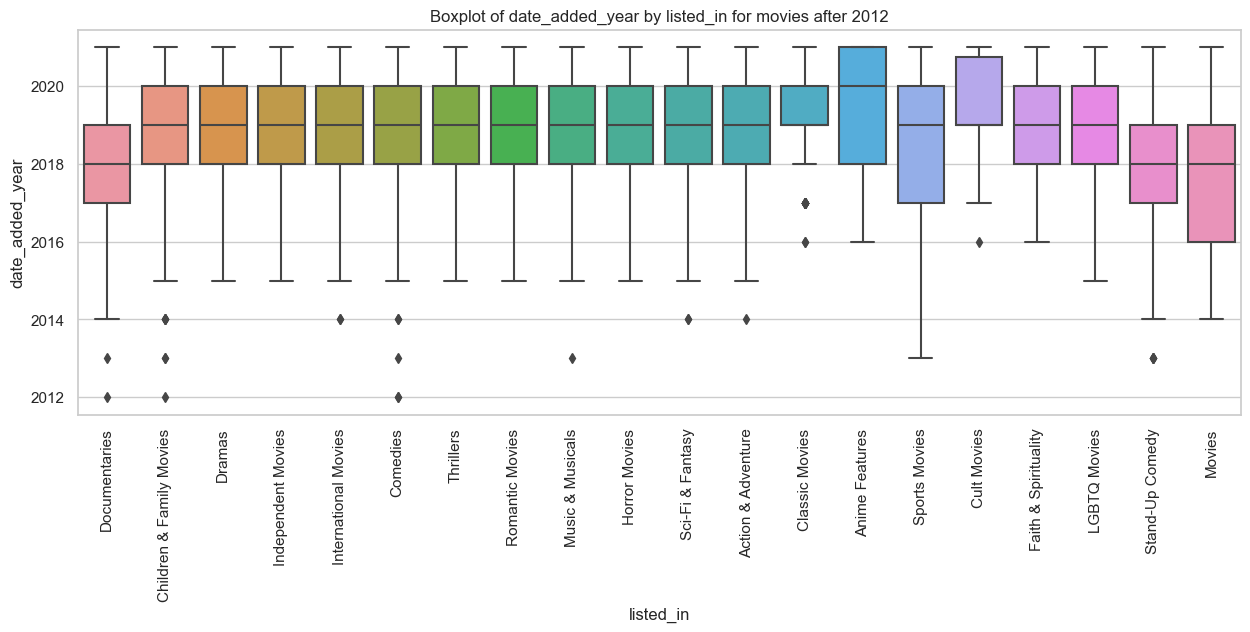

In [78]:
merge_df = movies_df.merge(listed_df, on='show_id', how='inner')
merge_df_trunc = merge_df.loc[merge_df['date_added_year'] >= 2012]
plt.figure(figsize=(15, 5))
sns.boxplot(data=merge_df_trunc, x="listed_in", y="date_added_year")
plt.title("Boxplot of date_added_year by listed_in for movies after 2012")
plt.xticks(rotation=90)

- Majority of the content has added during **2018 - 2020**

### TV Show Genre Analysis

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'International TV Shows'),
  Text(1, 0, 'TV Dramas'),
  Text(2, 0, 'TV Mysteries'),
  Text(3, 0, 'Crime TV Shows'),
  Text(4, 0, 'TV Action & Adventure'),
  Text(5, 0, 'Docuseries'),
  Text(6, 0, 'Reality TV'),
  Text(7, 0, 'Romantic TV Shows'),
  Text(8, 0, 'TV Comedies'),
  Text(9, 0, 'TV Horror'),
  Text(10, 0, 'British TV Shows'),
  Text(11, 0, 'Spanish-Language TV Shows'),
  Text(12, 0, 'TV Thrillers'),
  Text(13, 0, "Kids' TV"),
  Text(14, 0, 'TV Sci-Fi & Fantasy'),
  Text(15, 0, 'Anime Series'),
  Text(16, 0, 'Korean TV Shows'),
  Text(17, 0, 'Science & Nature TV'),
  Text(18, 0, 'Teen TV Shows'),
  Text(19, 0, 'TV Shows'),
  Text(20, 0, 'Stand-Up Comedy & Talk Shows'),
  Text(21, 0, 'Classic & Cult TV')])

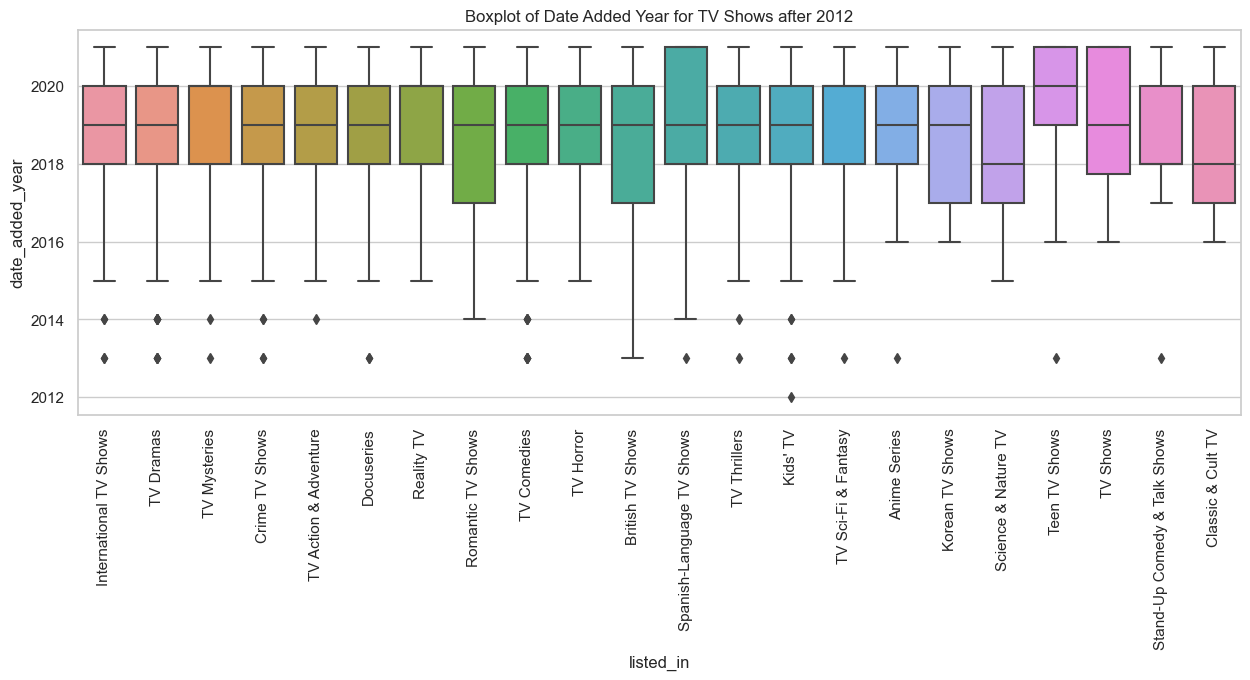

In [79]:
merge_df=tv_shows_df.merge(listed_df, on='show_id', how='inner')
merge_df_trunc = merge_df.loc[merge_df['date_added_year'] >= 2012]
plt.figure(figsize=(15, 5))
sns.boxplot(data=merge_df_trunc, x="listed_in", y="date_added_year")
plt.title('Boxplot of Date Added Year for TV Shows after 2012')
plt.xticks(rotation=90)

- Majority of the content has added during **2018 - 2020**.

- Majority of the content of **Movies/TV Shows** has added during **2018 - 2020 indicating Netflix popularity**.